In [1]:
using PyPlot
using LsqFit
include("mc_julia.jl") ;

In [2]:
include("../compute_ttv.jl")
importall TTVFaster

### 0. Read and plot TTV data 

In [3]:
dat1 = readdlm("../ttv_planet1.txt")
t1 = dat1[:,1]
dat2 = readdlm("../ttv_planet2.txt")
t2 = dat2[:,1];
data = Array{Float64}[t1,t2] ;

In [4]:
p_guesser(time::Array{Float64}) = mean(diff(time))
per_guess1 = p_guesser(t1)
per_guess2 = p_guesser(t2) ;

In [25]:
println(per_guess1,'\n',per_guess2)
# 5. venus and earth!

224.70076641863517
365.25630708152175


In [6]:
reg_transits(period::Float64,t0::Float64,n_trans::Int64) = [t0+period*(i-1) for i=1:n_trans]
#returns regular transit times ;

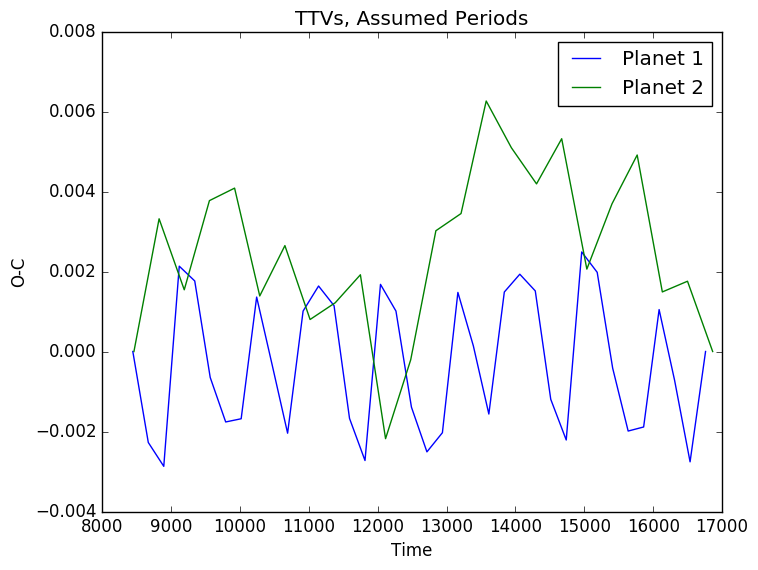

In [7]:
plot(t1,t1-reg_transits(per_guess1,t1[1],length(t1)),label="Planet 1")
plot(t2,t2-reg_transits(per_guess2,t2[1],length(t2)),label="Planet 2")
xlabel("Time")
ylabel("O-C")
title("TTVs, Assumed Periods")
legend(loc=0) ;

### 1. Create a wrapper for compute_ttv.jl which calls N(N-1) pairs of planets to compute the TTV of each planet due to all of the others.

In [24]:
fieldnames(TTVFaster.Planet_plane_hk)

5-element Array{Symbol,1}:
 :mass_ratio
 :period    
 :trans0    
 :ecosw     
 :esinw     

In [9]:
make_plane(m::Float64,p::Float64,t0::Float64,ec::Float64,es::Float64) = Planet_plane_hk(m, p, t0, ec, es)

make_plane (generic function with 1 method)

In [10]:
make_n_trans(data::Array{Array{Float64}}) = Int64[length(time) for time in data]

make_n_trans (generic function with 1 method)

In [11]:
function compute_ttv_pairs(n_p::Int64,n_trans_arr::Array{Int64},jmax::Int64,planets::Array{TTVFaster.Planet_plane_hk{Float64},1})
    
    ttvs = Array{Array{Float64}}(n_p)
    reg_times = Array{Array{Float64}}(n_p)
    n_p_t = length(n_trans_arr)
    
    for i=1:n_p #for all transiting planets, make an array of zero TTVS for each planet, reg times for each planet
        if i<=n_p_t
            ttvs[i] = zeros(n_trans_arr[i])
            reg_times[i] = reg_transits(planets[i].period,planets[i].trans0,n_trans_arr[i])
        else
            ttvs[i] = zeros(maximum(n_trans_arr))
            reg_times[i] = reg_transits(planets[i].period,planets[i].trans0,maximum(n_trans_arr))
        end  
    end
        
    for i=1:n_p-1 #for each planet
        for j=(i+1):n_p #go to each other planet
            time1 = reg_times[i]
            time2 = reg_times[j]
            ttvs1 = zeros(length(time1))
            ttvs2 = zeros(length(time2))
            compute_ttv!(jmax,planets[i],planets[j],time1,time2,ttvs1,ttvs2) #compute ttvs, add to array
            ttvs[i] .+= ttvs1 #add on to the TTVs
            ttvs[j] .+= ttvs2
        end
    end
    
    return (reg_times,ttvs,reg_times.+ttvs)
    
end

compute_ttv_pairs (generic function with 1 method)

### 2. Carry out an initial fit to the transit times of the two planets.

In [12]:
function ttv_model(times::Array{Array{Float64}},p::Array{Float64})
    
    #Apparently we actually get sensible fits when not making sure the parameters make sense
    #for (m,P,Psort,t0,ecos,esin) in zip(p[1:5:end],p[2:5:end],sort(p[2:5:end]),p[3:5:end],p[4:5:end],p[5:5:end])
    #    if (m <= 0.0)|(P <= 0.0)|(P != Psort)|(t0 <= 0.0)|(abs(ecos) >= 1.0)|(abs(esin) >= 1.0)
    #        flag = false
    #    end
    #end
    
   # if (sort(p[2:5:end])== p[2:5:end])&(abs(p[2:5:end])==p[2:5:end]) #Make sure that periods make sense
   #     flag=true
   # end
    
    n_p = length(p[1:5:end])
    n_trans_arr = make_n_trans(times)
    
    #if flag

    #Make planets
    planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p]

    #Compute TTVs
    regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)

    #Output linear array of transit times
    lin_out = Float64[]
    for i=1:length(n_trans_arr)
        append!(lin_out,trans_times[i])
    end

    return lin_out #regular transits plus the TTVS
        
    #else
        
    #    return fill(1.0e10,sum(n_trans_arr))
        
    #end
    
end

ttv_model (generic function with 1 method)

In [13]:
function fit_ttvs(times::Array{Array{Float64}}; n_p::Int64 = length(times))
     
    #1D array of times to make fitting easier
    lintimes = Float64[]
    for i=1:length(times)
        append!(lintimes,times[i])
    end
    
    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision
    
    p0 = zeros(5*n_p)
    #initialize params
    #p[1+5(i-1)]-p[5+5(i-1)] = mass_ratio, period, t0, ecosw, esinw for planet i
    for i=1:n_p
        p0[1+5*(i-1)] = 2.0e-6 #this is a terrestrial world hopefully
        p0[2+5*(i-1)] = p_guesser(times[i]) #guess the period
        p0[3+5*(i-1)] = times[i][1] #guess the time of transit
        p0[4+5*(i-1)] = 0.1 #small eccentricities to start with
        p0[5+5*(i-1)] = 0.1
    end
        
    fit = curve_fit(ttv_model,times,lintimes,weights,p0)
    
end

fit_ttvs (generic function with 1 method)

In [14]:
result = fit_ttvs(data) ;

In [23]:
parnames = ["M_1","P_1","t0_1","ecosw_1","esinw_1","M_2","P_2","t0_2","ecosw_2","esinw_2"]
for (nam,par) in zip(parnames,result.param)
    println("$nam = $par")
end

M_1 = 2.235101296215343e-6
P_1 = 224.70077045197777
t0_1 = 8445.49952245744
ecosw_1 = 0.007259046930495344
esinw_1 = 0.0035222482271572565
M_2 = 3.1241996571104925e-6
P_2 = 365.256362919657
t0_2 = 8461.759186153115
ecosw_2 = 0.01959010911371741
esinw_2 = 0.006308595698050496


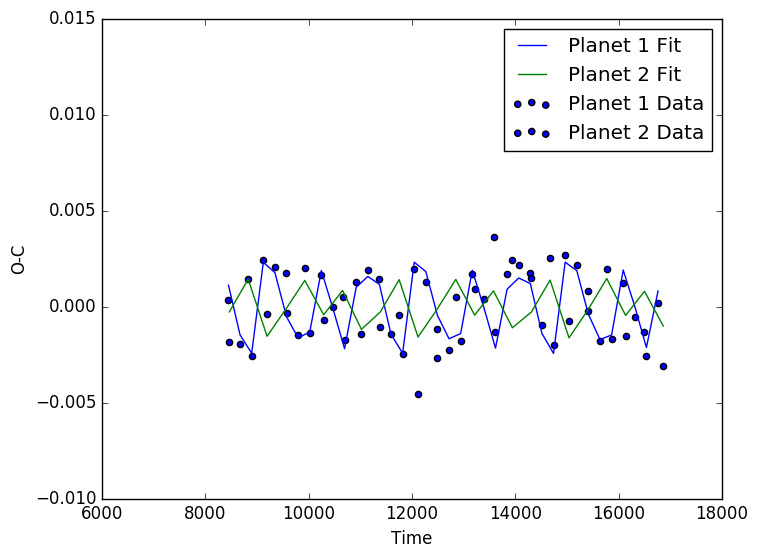

PyObject <matplotlib.legend.Legend object at 0x31f5a14d0>

P_1 = 224.70077045197777
t0_1 = 8445.49952245744
ecosw_1 = 0.007259046930495344
esinw_1 = 0.0035222482271572565
M_2 = 3.1241996571104925e-6
P_2 = 365.256362919657
t0_2 = 8461.759186153115
ecosw_2 = 0.01959010911371741
esinw_2 = 0.006308595698050496


In [16]:
function plot_ttvs(fit::LsqFit.LsqFitResult{Float64},times::Array{Array{Float64}})
    pars = fit.param
    n_p = length(pars[1:5:end])
    n_p_t = length(times)
    plans = TTVFaster.Planet_plane_hk{Float64}[]
    n_trans_arr = make_n_trans(times)
    for i=1:n_p
        push!(plans,make_plane(pars[1+5*(i-1)],pars[2+5*(i-1)],pars[3+5*(i-1)],pars[4+5*(i-1)],pars[5+5*(i-1)]))
    end
    regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,plans)
    for i=1:n_p
        if i<=n_p_t
            scatter(times[i],times[i]-regs[i],label="Planet $i Data")
        end
        plot(regs[i],ttvs[i],label="Planet $i Fit")
    end
    xlabel("Time")
    ylabel("O-C")
    legend(loc=0)
end
plot_ttvs(result,data)

#### The best fit TTVs are directly out of phase, while we know they shouldn't look like that; this is also a pretty poor fit to the data. Perhaps there is a 3rd planet!


### 3. Add in a third (non-transiting) planet to your model.  Make a grid in period, and optimize the fit over periods from 500-10,000 days & over ~10 phases for each period.  Plot the maximum likelihood versus period. Note 3: you’ll need to create a wrapper for curve_fit which allows the 3rd period to be fixed.

### Lets edit our model such that we can account for asking for extra planets

In [17]:
function curve_fit_nt(xdata::Array{Array{Float64}},ydata::Array{Float64},weights::Array{Float64},p0::Array{Float64},t0::Float64,P::Float64)
    
    function ttv_model_non_trans(times::Array{Array{Float64}},p::Array{Float64})

        #splice!(p,length(p)-1,[P,t0,p[end-1]]) #push in the period and phase of our planet

        n_p = length(times)+1
        n_trans_arr = make_n_trans(times)
        n_p_t = length(n_trans_arr)
        
        
        #Make planets
        planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p_t]
        push!(planes,make_plane(p[1+5*(n_p-1)],P,t0,p[2+5*(n_p-1)],p[3+5*(n_p-1)]))

        #Compute TTVs
        regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)

        #Output linear array of transit times
        lin_out = Float64[]
        for i=1:n_p_t
            append!(lin_out,trans_times[i])
        end

        return lin_out #regular transits plus the TTVS

    end
    
    return curve_fit(ttv_model_non_trans,xdata,ydata,weights,p0),ttv_model_non_trans
    
end

curve_fit_nt (generic function with 1 method)

In [18]:
function fit_ttv_non_trans(dat::Array{Array{Float64}};n_p::Int64 = length(dat)+1)

    P_grid = logspace(log10(500),4)
    phase_grid = collect(0.0:10:0.9)

    P_best = 0.0
    t0_best = 0.0
    fit_best = Float64[]
    chi_best = 1.0e100
    mod_best::Function = () -> ()

    lintimes = Float64[]
    for i=1:(n_p-1)
        append!(lintimes,dat[i])
    end

    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision

    p0 = zeros(5*(n_p-1))
    #initialize params
    #p[1]-p[5] = mass_ratio, period, t0, ecosw, esinw, first planet
    #p[6] - p[10] = same params but second planet
    for i=1:(n_p-1)
        p0[1+5*(i-1)] = 2.0e-6
        p0[2+5*(i-1)] = p_guesser(dat[i])
        p0[3+5*(i-1)] = dat[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
    
    append!(p0,[2.0e-6,0.1,0.1])
    

    for P in P_grid

        for phase in phase_grid

            t0 = phase*P

            (fit,modl) = curve_fit_nt(dat, lintimes, weights, p0, t0, P)
            
            chi2 = sum((fit.resid.^2).*weights)
            p0 = fit.param #best fit params to feed into the next iteration, should be a bit quicker
            
            if chi2 < chi_best
                chi_best = chi2
                P_best = P
                t0_best = t0
                fit_best = fit
                mod_best = modl
            end
            
        end
    end
    return fit_best,P_best,t0_best,mod_best
end

fit_ttv_non_trans (generic function with 1 method)

In [63]:
fit,P,t0,modl = fit_ttv_non_trans(data) ;

In [64]:
parnames = ["M_1","P_1","t0_1","ecosw_1","esinw_1","M_2","P_2","t0_2","ecosw_2","esinw_2","M_3","P_3","t0_3","ecosw_3","esinw_3"]
splice!(fit.param,length(fit.param)-1,[P,t0,fit.param[end-1]])
for (nam,par) in zip(parnames,fit.param)
    println("$nam = $par")
end
#This looks Jupiter-like, from the period; but the rest of the parameters are unphysical! Let's do MCMC to find better ones.

M_1 = 2.6476121486692508e-6
P_1 = 224.70078476904686
t0_1 = 8445.499215073849
ecosw_1 = 0.037104471102411246
esinw_1 = 0.007649075589200021
M_2 = 3.2590909822244243e-6
P_2 = 365.256439326292
t0_2 = 8461.758241414038
ecosw_2 = 0.04249898234958782
esinw_2 = 0.007097082255350571
M_3 = 8.312570713613962e-10
P_3 = 4516.7783243131125
t0_3 = 0.0
ecosw_3 = -169846.83005821164
esinw_3 = 11.30003409692001


In [61]:
data2d = hcat(vcat(t1,t2),vcat(t1,t2),[0.000347222 for i=1:length(vcat(t1,t2))])

62x3 Array{Float64,2}:
  8445.5   8445.5  0.000347222
  8670.2   8670.2  0.000347222
  8894.9   8894.9  0.000347222
  9119.6   9119.6  0.000347222
  9344.3   9344.3  0.000347222
  9569.0   9569.0  0.000347222
  9793.7   9793.7  0.000347222
 10018.4  10018.4  0.000347222
 10243.1  10243.1  0.000347222
 10467.8  10467.8  0.000347222
 10692.5  10692.5  0.000347222
 10917.2  10917.2  0.000347222
 11141.9  11141.9  0.000347222
     ⋮                        
 12844.8  12844.8  0.000347222
 13210.1  13210.1  0.000347222
 13575.4  13575.4  0.000347222
 13940.6  13940.6  0.000347222
 14305.9  14305.9  0.000347222
 14671.1  14671.1  0.000347222
 15036.4  15036.4  0.000347222
 15401.6  15401.6  0.000347222
 15766.9  15766.9  0.000347222
 16132.1  16132.1  0.000347222
 16497.4  16497.4  0.000347222
 16862.7  16862.7  0.000347222

In [60]:
function ttv_mcmc_nt(linear::Array{Float64},p)
    
    dif = diff(linear)
    ind = find(dif.<0.0)[1]
    n_trans_arr = Int64[length(linear[1:ind]),length(linear[(ind+1):end])]
    
    n_p = length(p[1:5:end])

    #Make planets
    planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p]

    #Compute TTVs
    regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)

    #Output linear array of transit times
    lin_out = Float64[]
    for i=1:length(n_trans_arr)
        append!(lin_out,trans_times[i])
    end

    return lin_out #regular transits plus the TTVS
    
end

ttv_mcmc_nt (generic function with 1 method)

In [75]:
p0 = fit.param #initial parameters. Let's mess with them slightly because curve_fit sucked.
perr = estimate_errors(fit)
splice!(perr,length(perr)-1,[0.005,1.0,perr[end-1]])
perr[11] = 0.5e-3
perr[14] = 0.1
p0[11] = 1.0e-3
p0[12] = 4333.0
p0[13] = data2d[1]
p0[14] = 0.1
p0[15] = 0.1
#We think this is jupiter so lets put in better params that are closer to the truth

15-element Array{Float64,1}:
 7.60546e-7 
 1.40723e-5 
 0.000297379
 0.0593303  
 0.0345984  
 4.88543e-7 
 2.95866e-5 
 0.000387526
 0.0470796  
 0.0275959  
 0.0005     
 0.005      
 1.0        
 0.1        
 0.0727084  

In [80]:
plog = ploglike(ttv_mcmc_nt,15,data2d)

chi2 (generic function with 1 method)

In [81]:
mc_run = mcmc(plog,p0,perr,10000)

Number of steps: 1000, acceptance rate: 0.3151333333333333
Number of steps: 2000, acceptance rate: 0.16126666666666667
Number of steps: 3000, acceptance rate: 0.1964
Number of steps: 4000, acceptance rate: 0.1890888888888889
Number of steps: 5000, acceptance rate: 0.21673333333333333
Number of steps: 6000, acceptance rate: 0.23455555555555554
Number of steps: 7000, acceptance rate: 0.24164444444444444
Number of steps: 8000, acceptance rate: 0.23986666666666667
Number of steps: 9000, acceptance rate: 0.24253333333333332
Number of steps: 10000, acceptance rate: 0.2418


walker_array([walker_record([walker([2.5553012355988703e-6,224.70075439171364,8445.49890929179,0.07286261607829118,0.02869577828330488,4.138983877543624e-6,365.2564275069179,8461.758665831658,0.07021138229348314,0.037284888092878915,0.001007291513993398,4332.993890573127,8445.503631758947,0.1141161086342145,0.1221992919441022],1557.3278807515749),walker([3.0623001518019476e-6,224.70076338411457,8445.49908306776,0.04153042727845556,0.03379301081483293,3.5451710316738804e-6,365.25644145884,8461.758234680605,0.061574488187515625,0.04024925040889582,0.0007971514584452488,4332.998504190433,8445.67359915232,0.1996610958023029,0.10153031638060325],897.3680820259931),walker([3.0623001518019476e-6,224.70076338411457,8445.49908306776,0.04153042727845556,0.03379301081483293,3.5451710316738804e-6,365.25644145884,8461.758234680605,0.061574488187515625,0.04024925040889582,0.0007971514584452488,4332.998504190433,8445.67359915232,0.1996610958023029,0.10153031638060325],897.3680820259931),walker([3.062

In [82]:
iburn = calc_iburn(mc_run)
#result not converging!

10000

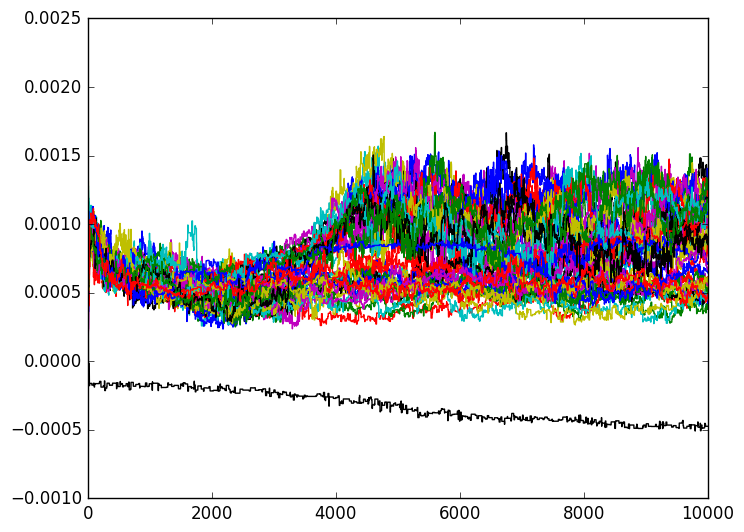

PyObject <matplotlib.text.Text object at 0x325e732d0>

In [86]:
plot_trace(mc_run,11,1)
xlabel("Step")
ylabel(L"$M_3$ \-- looks like Jupiter!")

# Looks like we just need to run it for more steps; my computer is having a hard time handling it because it is very old. Either more steps, or there's that one walker that just dives off into wherever the fuck its going